# HW2 - Data From The Web

## 1. Web Scraping 

We will first write all functions needed to extract the data from the websites and demonstrate how they work. Then we will complete the assignment using them.

In [150]:
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import pickle
%matplotlib inline

TOP_UNI_URL = 'https://www.topuniversities.com'
TIMES_URL = 'https://www.timeshighereducation.com'

### 1.1 Top Universities Website

After a quick look with Postman on the webside, we realised that the ranking table data were not given on the page but retrived and added with a script on a json file. We then had to directly get this file to obtain the information we need for this assignment.

In [2]:
TOP_WORLD_RANKING_FILE = TOP_UNI_URL + '/sites/default/files/qs-rankings-data/357051.txt'
ranking_top_uni = rq.get(TOP_WORLD_RANKING_FILE).json().get('data')

The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag.

In [3]:
top_unis = []
for uni in ranking_top_uni[:200]:
    top_unis.append({'Name' : uni.get('title'), 'Rank' : uni.get('rank_display').replace('=', ''), 
                     'Country' : uni.get('country'), 'Region' : uni.get('region'), 'Url' : uni.get('url')})
print(top_unis[:5])

[{'Name': 'Massachusetts Institute of Technology (MIT)', 'Rank': '1', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/massachusetts-institute-technology-mit'}, {'Name': 'Stanford University', 'Rank': '2', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/stanford-university'}, {'Name': 'Harvard University', 'Rank': '3', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/harvard-university'}, {'Name': 'California Institute of Technology (Caltech)', 'Rank': '4', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/california-institute-technology-caltech'}, {'Name': 'University of Cambridge', 'Rank': '5', 'Country': 'United Kingdom', 'Region': 'Europe', 'Url': '/universities/university-cambridge'}]


Here are the functions to obtain the amount of faculty members (total & international) and students (total & international)

In [4]:
def get_num_members(soup):
    return int(soup.find('div', class_='total faculty').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='inter faculty').find('div', class_='number').text.strip().replace(',', ''))

In [5]:
page = rq.get(TOP_UNI_URL + '/universities/ecole-polytechnique-fédérale-de-lausanne-epfl')
soup = BeautifulSoup(page.text, 'html.parser')
tot, inter = get_num_members(soup)
print('EPFL number of faculty members (total, international:)', tot, inter)

EPFL number of faculty members (total, international:) 1695 1300


In [6]:
def get_num_students(soup):
    return int(soup.find('div', class_='total student').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='total inter').find('div', class_='number').text.strip().replace(',', ''))

In [7]:
tot, inter = get_num_students(soup)
print('EPFL number of students (total, international:', tot, inter)

EPFL number of students (total, international: 10343 5896


In [8]:
problematic_uni = []
for uni in top_unis:
    page = rq.get(TOP_UNI_URL + uni['Url'])
    soup = BeautifulSoup(page.text, 'html.parser')
    try:
        tot_mem, inter_mem = get_num_members(soup)
        tot_stud, inter_stud = get_num_students(soup)
        uni['Tot_Mem'] = tot_mem
        uni['Inter_Mem'] = inter_mem
        uni['Tot_Stud'] = tot_stud
        uni['Inter_Stud'] = inter_stud
    except AttributeError: 
        problematic_uni.append(top_unis.index(uni))
        print('Could not fetch data from:', uni['Name'])

Could not fetch data from: New York University (NYU)
Could not fetch data from: Indian Institute of Science (IISc) Bangalore


As we can see two universities don't have the data on the topuniversities website so we will add them by hand watching on the website our self.

In [9]:
nyu = top_unis[problematic_uni[0]]
nyu['Tot_Mem'] = 7717
nyu['Inter_Mem'] = 604
nyu['Tot_Stud'] = 43860
nyu['Inter_Stud'] = 11593

bang = top_unis[problematic_uni[1]]
bang['Tot_Mem'] = 423
bang['Inter_Mem'] = 0
bang['Tot_Stud'] = 4071
bang['Inter_Stud'] = 47

In [10]:
print(top_unis[:5])

[{'Name': 'Massachusetts Institute of Technology (MIT)', 'Rank': '1', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/massachusetts-institute-technology-mit', 'Tot_Mem': 2982, 'Inter_Mem': 1679, 'Tot_Stud': 11067, 'Inter_Stud': 3717}, {'Name': 'Stanford University', 'Rank': '2', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/stanford-university', 'Tot_Mem': 4285, 'Inter_Mem': 2042, 'Tot_Stud': 15878, 'Inter_Stud': 3611}, {'Name': 'Harvard University', 'Rank': '3', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/harvard-university', 'Tot_Mem': 4350, 'Inter_Mem': 1311, 'Tot_Stud': 22429, 'Inter_Stud': 5266}, {'Name': 'California Institute of Technology (Caltech)', 'Rank': '4', 'Country': 'United States', 'Region': 'North America', 'Url': '/universities/california-institute-technology-caltech', 'Tot_Mem': 953, 'Inter_Mem': 350, 'Tot_Stud': 2255, 'Inter_Stud': 647}, {'Name': 'University of Cambridge', '

Now we will save those data in a pickle file to be able to use them without requesting everytime

In [11]:
with open('topunis.pickle', 'wb') as out:
    pickle.dump(top_unis, out)

In [31]:
with open('topunis.pickle', 'rb') as data:
    top_unis = pickle.load(data)

In [32]:
top_uni_df = pd.DataFrame.from_dict(top_unis).set_index('Rank').drop('Url', axis=1)
top_uni_df = top_uni_df[['Name', 'Country', 'Region', 'Tot_Stud', 'Inter_Stud', 'Tot_Mem', 'Inter_Mem']]

In [33]:
top_uni_df

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,11067,3717,2982,1679
2,Stanford University,United States,North America,15878,3611,4285,2042
3,Harvard University,United States,North America,22429,5266,4350,1311
4,California Institute of Technology (Caltech),United States,North America,2255,647,953,350
5,University of Cambridge,United Kingdom,Europe,18770,6699,5490,2278
6,University of Oxford,United Kingdom,Europe,19720,7353,6750,2964
7,UCL (University College London),United Kingdom,Europe,31080,14854,6345,2554
8,Imperial College London,United Kingdom,Europe,16090,8746,3930,2071
9,University of Chicago,United States,North America,13557,3379,2449,635


#### 1.1.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

In [124]:
best_ratio_a = top_uni_df.copy()
best_ratio_a['Members/Students ratio'] = top_uni_df['Tot_Mem'] / top_uni_df['Tot_Stud']
best_ratio_a = best_ratio_a.sort_values(['Members/Students ratio'], ascending=False)
best_ratio_a[:20]

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem,Members/Students ratio
Rank,,,,,,,,
4,California Institute of Technology (Caltech),United States,North America,2255,647,953,350,0.422616
16,Yale University,United States,North America,12402,2469,4940,1708,0.398323
6,University of Oxford,United Kingdom,Europe,19720,7353,6750,2964,0.342292
5,University of Cambridge,United Kingdom,Europe,18770,6699,5490,2278,0.292488
17,Johns Hopkins University,United States,North America,16146,4105,4462,1061,0.276353
2,Stanford University,United States,North America,15878,3611,4285,2042,0.269870
1,Massachusetts Institute of Technology (MIT),United States,North America,11067,3717,2982,1679,0.269450
186,University of Rochester,United States,North America,9636,2805,2569,488,0.266604
19,University of Pennsylvania,United States,North America,20639,4250,5499,1383,0.266437


In [125]:
best_ratio_a_plot = best_ratio_a.set_index('Name')

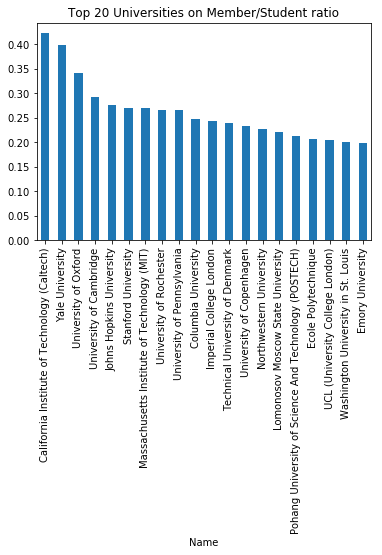

In [126]:
best_ratio_a_plot[:20]['Members/Students ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')

#### 1.1.b Which are the best universities in terms of ratio of international students?
Here are the top 20

In [138]:
best_ratio_b = top_uni_df.copy()
best_ratio_b['Int_Stud ratio'] = top_uni_df['Inter_Stud'] / top_uni_df['Tot_Stud']
best_ratio_b.sort_values(['Int_Stud ratio'], ascending=False)[:20]

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem,Int_Stud ratio
Rank,,,,,,,,
35,London School of Economics and Political Scien...,United Kingdom,Europe,9760,6748,1088,687,0.691393
12,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,Europe,10343,5896,1695,1300,0.570047
8,Imperial College London,United Kingdom,Europe,16090,8746,3930,2071,0.543567
200,Maastricht University,Netherlands,Europe,16385,8234,1277,502,0.502533
47,Carnegie Mellon University,United States,North America,13356,6385,1342,425,0.478062
7,UCL (University College London),United Kingdom,Europe,31080,14854,6345,2554,0.477928
92,University of St Andrews,United Kingdom,Europe,8800,4030,1140,485,0.457955
41,The University of Melbourne,Australia,Oceania,42182,18030,3311,1477,0.427434
127,Queen Mary University of London,United Kingdom,Europe,16135,6806,1885,801,0.421816


In [139]:
best_ratio_b_plot = best_ratio_b.set_index('Name').sort_values(['Int_Stud ratio'], ascending=False)[:20]

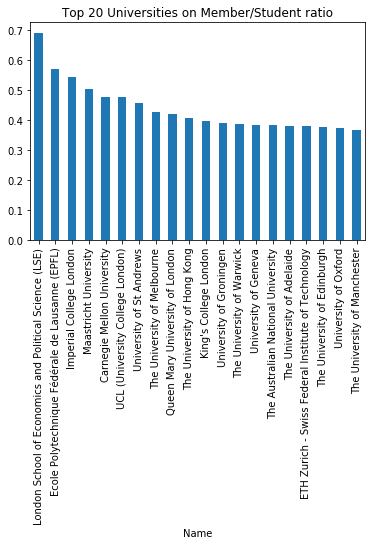

In [140]:
best_ratio_b_plot[:20]['Int_Stud ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')

#### 1.1.c Same questions aggregating by country:

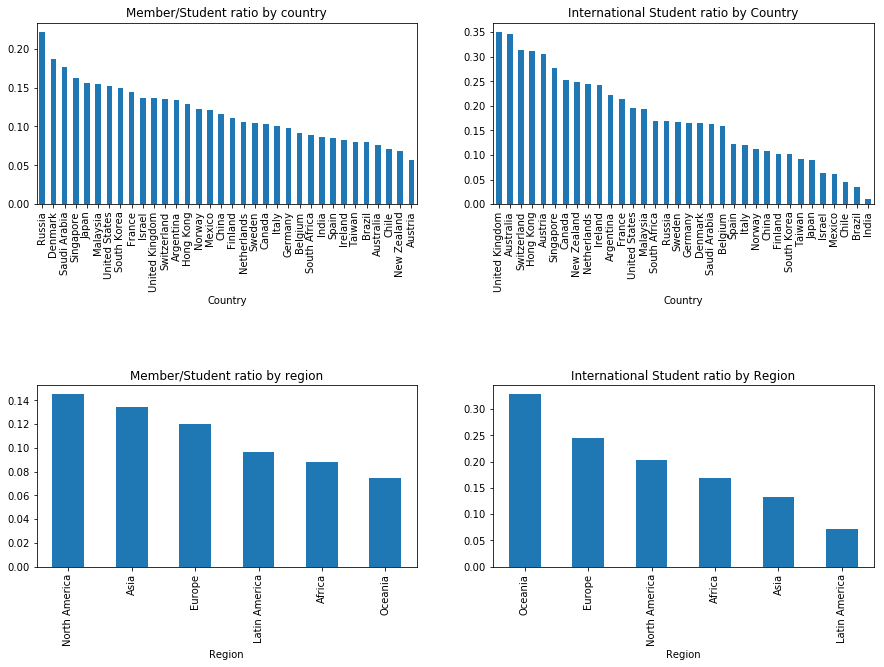

In [176]:
plot_country_df_a = best_ratio_a.groupby(['Country'])['Members/Students ratio'].mean()
plot_country_df_a = plot_country_df_a.sort_values(ascending=False)

plot_country_df_b = best_ratio_b.groupby(['Country'])['Int_Stud ratio'].mean()
plot_country_df_b = plot_country_df_b.sort_values(ascending=False)

plot_region_df_a = best_ratio_a.groupby(['Region'])['Members/Students ratio'].mean()
plot_region_df_a = plot_region_df_a.sort_values(ascending=False)

plot_region_df_b = best_ratio_b.groupby(['Region'])['Int_Stud ratio'].mean()
plot_region_df_b = plot_region_df_b.sort_values(ascending=False)



fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
plt.subplots_adjust(hspace = 1)
plot_country_df_a.plot.bar(ax=axes[0, 0], title='Member/Student ratio by country')
plot_country_df_b.plot.bar(ax=axes[0, 1], title='International Student ratio by Country')
plot_region_df_a.plot.bar(ax=axes[1, 0], title='Member/Student ratio by region')
plot_region_df_b.plot.bar(ax=axes[1, 1], title='International Student ratio by Region')

### 1.2 Times Higher Education Website

In [15]:
TOP_TIMES_RANKING_FILE = TIMES_URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
ranking_top_times = rq.get(TOP_TIMES_RANKING_FILE).json().get('data')
for key in ranking_top_times[2].keys(): 
    print("{}: {}". format(key,ranking_top_times[2].get(key)))


rank_order: 30
rank: =3
name: California Institute of Technology
scores_overall: 93.0
scores_overall_rank: 30
scores_teaching: 90.3
scores_teaching_rank: 1
scores_research: 97.5
scores_research_rank: 4
scores_citations: 99.5
scores_citations_rank: 10
scores_industry_income: 92.6
scores_industry_income_rank: 51
scores_international_outlook: 59.7
scores_international_outlook_rank: 322
record_type: private
member_level: 0
url: /world-university-rankings/california-institute-technology
nid: 128779
location: United States
stats_number_students: 2,209
stats_student_staff_ratio: 6.5
stats_pc_intl_students: 27%
stats_female_male_ratio: 31 : 69
aliases: California Institute of Technology caltech
subjects_offered: Architecture,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geology, Environmental, Earth & Marine Sciences,History, Philosophy & Theology,Languages, Literatures 

The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag. But this time the *Region* is not given by the website, no even on the specific pages. But this time it contains everything else, no need to scrap the specific pages.

In [16]:
top_times = []
for uni in ranking_top_times[:200]:
    top_times.append({'Name' : uni.get('name'), 'Rank' : uni.get('rank').replace('=', ''), 
                      'Country' : uni.get('location'), 'Region' : '',
                      'Tot_Stud' : int(uni.get('stats_number_students').replace(',', '')), 
                      'Inter_Stud' : round(int(uni.get('stats_number_students').replace(',', '')) * int(uni.get('stats_pc_intl_students').replace('%', '')) / 100),
                      'Tot_Mem' : round(int(uni.get('stats_number_students').replace(',', '')) / float(uni.get('stats_student_staff_ratio'))),
                      'Inter_Mem' : None})
print(ranking_top_times[:1])

[{'rank_order': '10', 'rank': '1', 'name': 'University of Oxford', 'scores_overall': '94.3', 'scores_overall_rank': '10', 'scores_teaching': '86.7', 'scores_teaching_rank': '5', 'scores_research': '99.5', 'scores_research_rank': '1', 'scores_citations': '99.1', 'scores_citations_rank': '15', 'scores_industry_income': '63.7', 'scores_industry_income_rank': '169', 'scores_international_outlook': '95.0', 'scores_international_outlook_rank': '24', 'record_type': 'master_account', 'member_level': '0', 'url': '/world-university-rankings/university-oxford', 'nid': 468, 'location': 'United Kingdom', 'stats_number_students': '20,409', 'stats_student_staff_ratio': '11.2', 'stats_pc_intl_students': '38%', 'stats_female_male_ratio': '46 : 54', 'aliases': 'University of Oxford', 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Eng

In [17]:
for uni in ranking_top_times[:200]:
    print("***************************************")
    for key in uni.keys(): 
        print("{}: {}".format(key, uni.get(key)))

***************************************
rank_order: 10
rank: 1
name: University of Oxford
scores_overall: 94.3
scores_overall_rank: 10
scores_teaching: 86.7
scores_teaching_rank: 5
scores_research: 99.5
scores_research_rank: 1
scores_citations: 99.1
scores_citations_rank: 15
scores_industry_income: 63.7
scores_industry_income_rank: 169
scores_international_outlook: 95.0
scores_international_outlook_rank: 24
record_type: master_account
member_level: 0
url: /world-university-rankings/university-oxford
nid: 468
location: United Kingdom
stats_number_students: 20,409
stats_student_staff_ratio: 11.2
stats_pc_intl_students: 38%
stats_female_male_ratio: 46 : 54
aliases: University of Oxford
subjects_offered: Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geography,Geology, Environmental, Earth & Marine Sciences,H

nid: 559
location: United States
stats_number_students: 31,772
stats_student_staff_ratio: 16.5
stats_pc_intl_students: 10%
stats_female_male_ratio: 48 : 52
aliases: University of Maryland, College Park
subjects_offered: Accounting & Finance,Agriculture & Forestry,Architecture,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Communication & Media Studies,Computer Science,Economics & Econometrics,Education,Electrical & Electronic Engineering,General Engineering,Geography,Geology, Environmental, Earth & Marine Sciences,History, Philosophy & Theology,Languages, Literatures and Linguistics,Law,Mathematics & Statistics,Mechanical & Aerospace Engineering,Other Health,Physics & Astronomy,Politics & International Studies (incl Development Studies),Psychology,Sociology,Sport Science,Veterinary Science
***************************************
rank_order: 700
rank: =70
name: Boston University
scores_overall: 65.4
scores_overall

scores_overall_rank: 1710
scores_teaching: 30.5
scores_teaching_rank: 372
scores_research: 36.2
scores_research_rank: 225
scores_citations: 87.0
scores_citations_rank: 133
scores_industry_income: 88.5
scores_industry_income_rank: 62
scores_international_outlook: 81.1
scores_international_outlook_rank: 126
record_type: master_account
member_level: 0
url: /world-university-rankings/university-cape-town
nid: 567
location: South Africa
stats_number_students: 20,775
stats_student_staff_ratio: 11.7
stats_pc_intl_students: 18%
stats_female_male_ratio: 53 : 47
aliases: University of Cape Town
subjects_offered: Accounting & Finance,Archaeology,Architecture,Chemical Engineering,Chemistry,Computer Science,Economics & Econometrics,Education,Electrical & Electronic Engineering,General Engineering,Geography,Geology, Environmental, Earth & Marine Sciences,History, Philosophy & Theology,Languages, Literatures and Linguistics,Law,Mathematics & Statistics,Mechanical & Aerospace Engineering,Medicine & De

scores_research: 32.4
scores_research_rank: 275
scores_citations: 91.9
scores_citations_rank: 78
scores_industry_income: 39.6
scores_industry_income_rank: 493
scores_international_outlook: 99.8
scores_international_outlook_rank: 1
record_type: master_account
member_level: 6
url: /world-university-rankings/university-luxembourg
nid: 131698
location: Luxembourg
stats_number_students: 4,969
stats_student_staff_ratio: 14.6
stats_pc_intl_students: 57%
stats_female_male_ratio: 50 : 50
aliases: University of Luxembourg
subjects_offered: Accounting & Finance,Biological Sciences,Business & Management,Civil Engineering,Computer Science,Economics & Econometrics,Education,Electrical & Electronic Engineering,General Engineering,Law,Mathematics & Statistics,Mechanical & Aerospace Engineering,Medicine & Dentistry,Physics & Astronomy,Psychology
***************************************
rank_order: 1800
rank: =179
name: University of Twente
scores_overall: 53.8
scores_overall_rank: 1800
scores_teaching: 

Now we will save those data in a pickle file to be able to use them without requesting everytime

In [18]:
with open('toptimes.pickle', 'wb') as out:
    pickle.dump(top_times, out)

In [6]:
with open('toptimes.pickle', 'rb') as data:
    top_times = pickle.load(data)

In [7]:
top_times_df = pd.DataFrame.from_dict(top_times).set_index('Rank')
top_times_df = top_times_df[['Name', 'Country', 'Region', 'Tot_Stud', 'Inter_Stud', 'Tot_Mem', 'Inter_Mem']]

In [8]:
top_times_df

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,University of Oxford,United Kingdom,,20409,7755,1822,None
2,University of Cambridge,United Kingdom,,18389,6436,1687,None
3,California Institute of Technology,United States,,2209,596,340,None
3,Stanford University,United States,,15845,3486,2113,None
5,Massachusetts Institute of Technology,United States,,11177,3800,1285,None
6,Harvard University,United States,,20326,5285,2284,None
7,Princeton University,United States,,7955,1909,958,None
8,Imperial College London,United Kingdom,,15857,8721,1391,None
9,University of Chicago,United States,,13525,3381,2181,None


### TODO: Plot graph answer question 2

This function prepare the names for the merge. We noticed that in one of the rankings the name is present as well as an abreviation of the university name. For exemple "Ecole polytechnique federale de lausanne (EPFL)" and in the othe rankng the abreviation was not present. Because of that we remove all abreviations of that type. We also remove some types of ponctuation and blank spaces.  

In [9]:
import re

def cleanName(name): 
    name = name.lower()
    name = re.sub(r"\(.+\)", ' ', name)
    name = name.replace('the', '')
    name = name.replace('é', '')
    name = name.replace('-', ' ')
    name = name.replace('—', ' ')
    name = name.replace('–', ' ')
    name = re.sub(r"\s+", ' ', name)
    name = name.strip(' ')
    
    return name

Here we transform the names of the universities with `cleanName` and we merge the two frames together. We perform an outer join in order to keep university that doesn't have match in the other ranking. 

In [10]:
top_uni_df['Name'] = top_uni_df['Name'].map(lambda name: cleanName(name))
top_times_df['Name'] = top_times_df['Name'].map(lambda name: cleanName(name))

merged_df = top_times_df.merge(top_uni_df, on=['Name'],  how='outer')

In [11]:
merged_df[:100]

,Name,Country_x,Region_x,Tot_Stud_x,Inter_Stud_x,Tot_Mem_x,Inter_Mem_x,Country_y,Region_y,Tot_Stud_y,Inter_Stud_y,Tot_Mem_y,Inter_Mem_y
0,university of oxford,United Kingdom,,20409.0,7755.0,1822.0,None,United Kingdom,Europe,19720.0,7353.0,6750.0,2964.0
1,university of cambridge,United Kingdom,,18389.0,6436.0,1687.0,None,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0
2,california institute of technology,United States,,2209.0,596.0,340.0,None,United States,North America,2255.0,647.0,953.0,350.0
3,stanford university,United States,,15845.0,3486.0,2113.0,None,United States,North America,15878.0,3611.0,4285.0,2042.0
4,massachusetts institute of technology,United States,,11177.0,3800.0,1285.0,None,United States,North America,11067.0,3717.0,2982.0,1679.0
5,harvard university,United States,,20326.0,5285.0,2284.0,None,United States,North America,22429.0,5266.0,4350.0,1311.0
6,princeton university,United States,,7955.0,1909.0,958.0,None,United States,North America,8069.0,1793.0,1007.0,246.0
7,imperial college london,United Kingdom,,15857.0,8721.0,1391.0,None,United Kingdom,Europe,16090.0,8746.0,3930.0,2071.0
8,university of chicago,United States,,13525.0,3381.0,2181.0,None,United States,North America,13557.0,3379.0,2449.0,635.0
9,eth zurich swiss federal institute of technolo...,Switzerland,,19233.0,7309.0,1317.0,None,NaN,NaN,NaN,NaN,NaN,NaN


### TODO: Fixing regions problem from the Times dataset